## Solaris Multimodal Preprocessing Library
# Tutorial Part 1: Pipelines

Preprocessing imagery for geospatial deep learning can involve many steps.  Tiling large images into manageably-sized tiles, as can be done with the `solaris` `tile` subpackage, is one important step.  However, it is often necessary or desirable to modify the imagery itself to bring out key features or combine data from multiple sources.  To do that, the `solaris` `preproc` subpackage provides a powerful syntax for executing image processing workflows.

The `preproc` subpackage contains more than 60 classes, each of which does some specific data manipulation task.  By connecting them together, the user can build out image processing tasks of arbitrary complexity.  The syntax for doing so uses only two symbols: the `*` symbol to create pipelines, and the `+` symbol for data branching.  These are further discussed below.

The classes can work together like this because they are all subclasses of the `PipeSegment` base class, which handles all the details behind the scenes.  For example, intermediate results are stored in RAM (making the library RAM-intensive but quite fast) and these intermediate results are deleted as soon as they are no longer needed.  In this functional programming approach, the user just specifies what data processing he or she wants to happen, and the implementation is taken care of automatically.

This tutorial will show different ways of using the `preproc` subpackage with three realistic examples.  In the first example, a pipeline will be created to compute an image's normalized difference vegetation index.  In the second example, a workflow with branching will be created to do pansharpening.  In the final example, complex synthetic aperture radar data will be processed into readily-interpretable imagery.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import solaris.preproc.pipesegment as pipesegment
import solaris.preproc.image as image
import solaris.preproc.sar as sar
import solaris.preproc.optical as optical
import solaris.preproc.label as label

plt.rcParams['figure.figsize'] = [4, 4]
datadir = '../../../solaris/data/preproc_tutorial'

/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sol/conda/envs/solaris/lib/python3.7/site-packages/tensorf

## Example 1: A Simple Pipeline

For the first example, let's create an image processing pipeline that will take a multispectral image and generate its normalized difference vegetation index (NDVI), a measurement that shows where the plants are.  It helps to start by picturing the task as a flowchart:

<img src="../../../solaris/data/preproc_tutorial/example1flowchart.png">

This is a pipeline where the output of each block is fed in as the input to the next block.  Here's the code:

In [2]:
mypipeline = (
    image.LoadImage(os.path.join(datadir, 'ms1.tif'))
    * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
    * image.SaveImage(os.path.join(datadir, 'output1.tif'))
)

mypipeline()

The first command, `mypipeline = (...)`, creates an object in memory (actually, a linked list of objects) describing the desired workflow.  Once that's done, the computer knows what work to do, but the work hasn't actually happened yet.  The work all happens when the object is called with the second command, `mypipeline()`.

Let's look at the first command more closely.  The new object `mypipeline` is built out of three objects representing each of the three steps in the flowchart.  These three objects are all instances of various classes in the `preproc` library.

Objects of the `LoadImage` and `SaveImage` classes load and save a geotiff file, including available metadata.  The `BandMath` class does calculations with the different bands of an image.  The NDVI is defined as the difference of the near-infrared and red bands divided by their sum, and in our sample image the near-infrared and red bands are bands 3 and 2, respectively, which is why the formula looks the way it does.  The 0.1 in the denominator is just there to prevent division by zero.

The `*` symbol plays a special role with classes that inherit from the `PipeSegment` base class, as mentioned in the introduction.  (Except for a couple special cases, every class in `preproc` is a subclass of `PipeSegment`.)  The `*` symbol tells the computer that we want to use the output of the preceeding object as the input to the following object.  In this way, the `mypipeline = (...)` command is a complete description of the flowchart above.

In any case, did the code actually work?  To find out, we could look at the output image, `output1.tif`.  With more complicated workflows it's often convenient to check intermediate results without the hassle of writing things to disk and opening them from there.  That's where the `ShowImage` and `ImageStats` classes come in.  The former will display the image and the latter will print descriptive statistics about it.  These classes pass on their input images unchanged, so they can be inserted anywhere into the pipeline that this information would be helpful.

Visible Spectrum


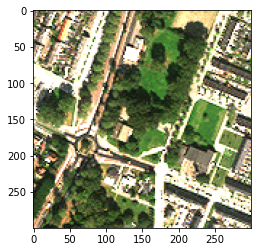

Normalized Difference Vegetation Index


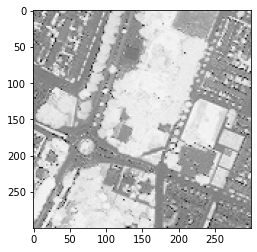

ms1: 1 bands, 300x300, float64, {'geotransform': (593270.2919143771, 1.0000483155950517, 0.0, 5747657.4158721585, 0.0, -1.0000483155950517), 'projection_ref': 'PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199...

        min       max      mean    median      std    pos  zero   neg  nan
0 -0.972502  0.997769  0.440329  0.430321  0.35757  83584   288  6128    0



In [3]:
my_pipeline_with_output = (
    image.LoadImage(os.path.join(datadir, 'ms1.tif'))
    * image.ShowImage(bands=[2,1,0], vmin=0, vmax=250, caption='Visible Spectrum')
    * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
    * image.SaveImage(os.path.join(datadir, 'output1.tif'))
    * image.ShowImage(caption='Normalized Difference Vegetation Index')
    * image.ImageStats()
)

my_pipeline_with_output()

It worked!  The NDVI ranges from -1 to 1 as expected, with vegetation indicated in white and everything else in gray or black.

Note that `output1.tif` will only contain the result of the calculation, not the original image.  Creating an output image with both of those things uses branching, which is shown in Example 2.

## Example 1 Follow-Up: Building a Reusable Class

In the code snippets above, we created objects describing workflows, then called them to do the work.  It's often better to start by defining a new class, from which such objects can be created.  For the pipeline in this example, a class can be created like this:

In [4]:
class MyPipeline(pipesegment.PipeSegment):
    def __init__(self):
        super().__init__()
        self.feeder = (
            image.LoadImage(os.path.join(datadir, 'ms1.tif'))
            * sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
            * image.SaveImage(os.path.join(datadir, 'output1.tif'))
        )

my_pipeline_instance = MyPipeline()
my_pipeline_instance()

The class's constructor has a boilerplate `super().__init__()` command, then sets `self.feeder` to the desired workflow.  However, this class isn't very useful in real life, because the input and output paths are hardwired into the code.  To preserve flexibility, let's send them in as arguments to the constructor.  We'll also give variable names to all the different blocks of the flowchart, to more cleanly separate the descriptions of the individual blocks from the logic of how they are wired together.

In [5]:
class MyBestPipeline(pipesegment.PipeSegment):
    def __init__(self, input_path, output_path):
        super().__init__()
        load = image.LoadImage(input_path)
        ndvi = sar.BandMath(lambda x: (x[3] - x[2]) / (x[3] + x[2] + 0.1))
        save = image.SaveImage(output_path)
        self.feeder = load * ndvi * save

my_input_path = os.path.join(datadir, 'ms1.tif')
my_output_path = os.path.join(datadir, 'output1.tif')
my_best_pipeline_instance = MyBestPipeline(my_input_path, my_output_path)
my_best_pipeline_instance()

The best part about defining a class, instead of just creating the object directly, is that the class is also a subclass of the `PipeSegment` base class.  That gives us the option of using our new class as a building block when building up a more-complicated workflow in the future.